In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer 
from nltk.stem import SnowballStemmer

import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix

## Función preprocesamiento

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
spanish_stopwords = stopwords.words('spanish')
non_words = list(string.punctuation)
non_words.extend(['¿', '¡'])
stemmer = SnowballStemmer('spanish')

In [4]:
corpus = "HOLA, ¿cómo estás?. #VivaChile @xd www.google.com https://www.google.com  http://www.google.com aaaaaa ¡Buenísimo! a.b"

In [5]:
corpus2 = re.sub(r'^RT[\s]+', '', corpus)  #Remover RT
corpus2 = re.sub(r'https?:\/\/\S+', '', corpus2)   #Remover hyperlinks
corpus2 = re.sub(r'www\S+', '', corpus2)   #Remover links
corpus2 = re.sub(r'#\S+', '', corpus2)    #Remover Hashtags
corpus2 = corpus2.replace('.', ' ')   #Cambiar . por espacio (algunas noticias no tienen esta separación)
corpus2

'HOLA, ¿cómo estás?   @xd     aaaaaa ¡Buenísimo! a b'

In [5]:
#Tokenizador que deja todo en minusculas, elimina @usuario, y reduce secuencia de mas de 3 caracteres iguales seguidos
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

In [7]:
tokens = tokenizer.tokenize(corpus2)

In [8]:
#Eliminar stopwords y puntuación

clean = []
for word in tokens:
    if (word not in spanish_stopwords and word not in non_words):
        clean.append(word)

In [9]:
print('Tokens principio:', tokens)
print('Tokens limpios:', clean)

Tokens principio: ['hola', ',', '¿', 'cómo', 'estás', '?', 'aaa', '¡', 'buenísimo', '!', 'a', 'b']
Tokens limpios: ['hola', 'cómo', 'aaa', 'buenísimo', 'b']


In [10]:
corpus_stem = []

for word in clean:
    stem_word = stemmer.stem(word)
    corpus_stem.append(stem_word)

In [11]:
corpus_stem

['hol', 'com', 'aaa', 'buenisim', 'b']

In [2]:
def process_corpus(corpus):
    '''
    Input:
        corpus: (string) con el texto a procesar 
    Output:
        clean_corpus: (list) con el texto tokenizado y limpio
    '''
    spanish_stopwords = stopwords.words('spanish')  #Stopwords en español
    non_words = list(string.punctuation)   #Símbolos de puntuación
    non_words.extend(['¿', '¡', '”', '“', '«', '»', '’', '‘'])     #Símbolos de puntuación en español
    stemmer = SnowballStemmer('spanish')   #Stemming en español
    
    
    corpus2 = re.sub(r'^RT[\s]+', '', corpus)  #Remover RT
    corpus2 = re.sub(r'https?:\/\/\S+', '', corpus2)   #Remover hyperlinks
    corpus2 = re.sub(r'www\S+', '', corpus2)   #Remover links
    corpus2 = re.sub(r'#\S+', '', corpus2)    #Remover Hashtags
    corpus2 = corpus2.replace('.', ' ')   #Cambiar . por espacio (algunas noticias no tienen esta separación)
    
    #Tokenizador que deja todo en minusculas, elimina @usuario (ciertas noticias tienen tweets), y reduce secuencia de mas de 3 caracteres iguales seguidos
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    
    tokens = tokenizer.tokenize(corpus2)  #tokenizacion del corpus
    
    clean_corpus = []
    for word in tokens:
        if (word not in spanish_stopwords and word not in non_words):
            stem_word = stemmer.stem(word)  #stemming
            clean_corpus.append(stem_word)  #se agrega la palabra a la lista del corpus limpio
    
    return clean_corpus

In [13]:
process_corpus(corpus)

['hol', 'com', 'aaa', 'buenisim', 'b']

## Preprocesamiento de las noticias

In [14]:
excel = pd.read_excel("Datos.xlsx")  #Cargar datos
excel = excel.dropna()
display(excel.head(10))   #Ver las primeras 10 noticias
display(excel.tail(10))    #Ver las ultimas 10 noticias

,Titulo,Cuerpo,Clase
0,Delfines calientes preparan nuevo espectáculo ...,"\n En la Universidad Maritima de Ovlaks, Litua...",0
1,Nueva especie: los perros koalas,"\nAUSTRALIA.- Según el dr. Adret Koene, esta n...",0
2,El viejo pascuero será degollado en vivo,"\nEn la madrugada de hoy, un grupo de terroris...",0
3,Paris Hilton es Satanica,\nParis Hilton es considerada una de las mujer...,0
4,Decretan Alerta Ambiental en Plaza de Armas,\nYa los escolares pasaron de moda con sus pro...,0
5,Rave Cristiana todo un éxito en la cuarta y qu...,\nLa rave cristiana lleva más de dos mil años ...,0
6,Los niños pre-escolares apoyan el paro estudia...,"\nCon casi 6 meses de protestas, los estudiant...",0
7,"Cáos en el complejo clínico ""Contigo Aprendo""","\nLas nuevas tendencias sexuales masculinas, e...",0
8,Sernac demanda a Carozzi por productos en mal ...,"\nDon Luis Ansoe Mowes, un consumidor indignad...",0
9,MierDonals inagura nuevo restorán en el corazó...,\nCEMETERIO GENERAL.- Con una billonaria inver...,0


,Titulo,Cuerpo,Clase
37713,Rusia cerrará temporalmente sus fronteras con ...,Moscú anunció este jueves (30.01.2020) el cier...,1
37714,Elecciones internas PS: Álvaro Elizalde y Maya...,Este domingo se dio inicio a la elección inter...,1
37715,Marine Le Pen vs. Emmanuel Macron: ¿qué presid...,América Latina rara vez llega a figurar en las...,1
37716,"Defensoría de la Niñez condena la ""criminaliza...",Tras los últimos hechos de violencia ocurridos...,1
37717,Hong Kong vuelve a protestar a pesar de la pro...,"La nueva protesta tiene lugar en Yuen Long, la...",1
37718,Polonia: alcalde muere tras ser apuñalado en m...,"El alcalde de Gdansk, Pawel Adamowicz, terminó...",1
37719,Se abre al público la restaurada Escotilla 8 d...,Ayer se abrió al público la renovada Escotilla...,1
37720,Fiscalía peruana pide arraigo nacional para PPK,El equipo especial anticorrupción de la Fiscal...,1
37721,"China pide a EE.UU. y Corea del Norte ""contenc...","El ministro chino de Asuntos Exteriores, Wang ...",1
37722,El Senado vota por continuar el proceso y llev...,El Senado brasileño se pronunció hoy por una c...,1


In [15]:
news_dict = excel.to_dict()

In [16]:
titulos = news_dict['Titulo']
cuerpos = news_dict['Cuerpo']
clases = news_dict['Clase']

In [17]:
titulos_procesados = {}
for i, titulo in titulos.items():
    titulos_procesados[i] = process_corpus(titulo)

In [18]:
cuerpos_procesados = {}
for i, cuerpo in cuerpos.items():
    cuerpos_procesados[i] = process_corpus(cuerpo)

In [21]:
len(titulos_procesados)

37723

In [23]:
#Ejemplos
print('\033[94m Titulo:', titulos_procesados[0], '\033[92m Cuerpo:', cuerpos_procesados[0], '\033[93m Clase:', clases[0])
print('\033[94m Titulo:', titulos_procesados[37722], '\033[92m Cuerpo:', cuerpos_procesados[37722], '\033[93m Clase:', clases[37722])

 Titulo: ['delfin', 'calient', 'prep', 'nuev', 'espectacul', 'iquiqueñ']  Cuerpo: ['univers', 'maritim', 'ovlaks', 'lituani', 'grup', 'cientif', 'pescador', 'logr', 'constru', 'aparat', 'logr', 'codific', 'part', 'son', 'emit', 'criatur', 'dr', 'antros', 'jolsor', 'biolog', 'marin', 'encontr', 'fras', 'emit', 'delfin', 'conten', 'sexual', 'fuert', 'hac', 'referent', 'aparat', 'reproductor', 'femenin', 'abre', 'pelican', 'fras', 'mas', 'repit', 'pon', 'muj', 'frent', 'delfin', 'vam', 'ahog', 'pendej', 'mierd', 'vam', 'pis', 'herman', 'dic', 'pon', 'niñ', 'frent', 'pon', 'hombr', 'sol', 'asient', 'cabez', 'grit', 'aweona', 'famos', 'bailarin', 'morandi', 'campañ', 'marl', 'oliveir', 'habl', 'adiccion', 'delfin', 'delfin', 'animal', 'lind', 'siempr', 'trat', 'ten', 'cerc', 'cas', 'dos', 'gomos', 'mas', 'dur', 'vibr', 'rie', 'ecolog', 'chilen', 'quier', 'constru', 'delfinari', 'ademas', 'constru', 'mitic', 'caf', 'entrepiern', 'conch', 'mar']  Clase: 0
 Titulo: ['sen', 'vot', 'continu', 'p

In [24]:
noticias_preprocesadas = {'Titulo': titulos_procesados, 'Cuerpo': cuerpos_procesados, 'Clase': clases}

In [25]:
#Guardar datos
with open('noticias.pickle', 'wb') as handle:
    pickle.dump(noticias_preprocesadas, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
#Datos de testeo
excel = pd.read_excel("Testeo.xlsx")  #Cargar datos
excel = excel.dropna()
display(excel.head(10))   #Ver las primeras 10 noticias
display(excel.tail(10))    #Ver las ultimas 10 noticias

,Titulo,Cuerpo,Clase
0,Policía premiará con gasolina de por vida a qu...,La Policía Nacional del Perú anunció que premi...,0
1,Meche Aráoz: Hallan indicios de corrupción mie...,Indignante pero esperado. Según una reciente i...,0
2,Esposo de Keiko encontró trabajo virtual pero ...,"Una lástima. El esposo de Keiko Fujimori, can...",0
3,La naturaleza se recupera: aparecen miles de a...,La cuarentena ha logrado que la naturaleza re...,0
4,Verónika acepta que unión con Cerrón fue un ER...,Tras aceptar que cometió un ERROR con mayúscul...,0
5,Malo y gritón del equipo extrañan cancelar las...,"Todos la pasan mal en la cuarentena, especia...",0
6,Pastor exige vacuna contra COVID-19 porque no ...,"Indignado y sin recibir diezmos, un milagroso...",0
7,Para mala suerte de Greta Thunberg y su velero...,Una desagradable noticia. La activista Greta T...,0
8,Para calmar ánimos: Piñera ordena cambiar los ...,Harto de no saber cómo calmar las protestas de...,0
9,Poder Judicial reconoció matrimonio civil entr...,Luego de varias instancias y varios periodista...,0


,Titulo,Cuerpo,Clase
2973,Angustia de familia de víctimas de COVID-19 se...,Llegaron al auditorio del edificio de la Defen...,1
2974,Fiscalía llama a rendir versión a María Paula ...,"La ministra de Gobierno, María Paula Romo; el ...",1
2975,"Plátano, alimento ""estrella"" en la Costa duran...",Desde pequeñas las hermanas Melissa y Michelle...,1
2976,Astinave entra a vender acciones por más de $8...,Astinave venderá las acciones que tiene en el ...,1
2977,"Alcalde de Samborondón, Juan José Yúnez, confi...","Juan José Yúnez, alcalde de Samborondón, confi...",1
2978,"Muere Jean Kennedy Smith, la única hermana sob...","Jean Kennedy Smith, la última hermana viva del...",1
2979,Teatro Centro de Arte reabre sus puertas con c...,Luego de cuatro meses de mantener las puertas ...,1
2980,"El Salvador, sin casos de coronavirus, decreta...",El Salvador y Guatemala tomaron el martes las ...,1
2981,Opciones para aprender el sistema de lenguaje ...,La sociedad y su entorno dieron un cambio rotu...,1
2982,"En su cumpleaños 100, una mujer cumplió su sue...","Para su cumpleaños número 100, Ruth Bryant cum...",1


In [27]:
test_dict = excel.to_dict()

In [28]:
titulos = test_dict['Titulo']
cuerpos = test_dict['Cuerpo']
clases = test_dict['Clase']

In [29]:
titulos_procesados = {}
for i, titulo in titulos.items():
    titulos_procesados[i] = process_corpus(titulo)

In [30]:
cuerpos_procesados = {}
for i, cuerpo in cuerpos.items():
    cuerpos_procesados[i] = process_corpus(cuerpo)

In [31]:
len(titulos_procesados)

2982

In [32]:
#Ejemplos
print('\033[94m Titulo:', titulos_procesados[0], '\033[92m Cuerpo:', cuerpos_procesados[0], '\033[93m Clase:', clases[0])
print('\033[94m Titulo:', titulos_procesados[2981], '\033[92m Cuerpo:', cuerpos_procesados[2981], '\033[93m Clase:', clases[2981])

 Titulo: ['polic', 'premi', 'gasolin', 'vid', 'encuentr', 'general', 'donayr']  Cuerpo: ['polic', 'nacional', 'peru', 'anunc', 'premi', 'gasolin', 'vid', 'logr', 'hall', 'parader', 'ahor', 'profug', 'excongres', 'edwin', 'donayr', 'sentenci', 'rob', 'gasolin', 'ejercit', 'peruan', 'segun', 'institu', 'edwin', 'donayr', 'inubic', 'contest', 'whatsapp', 'haran', 'posibl', 'hall', 'mejor', 'si', 'colabor', 'ciudadan', 'interes', 'lanz', 'anunci', 'polic', 'recib', 'mil', 'notif', 'posibl', 'escondit', 'general', 'embarg', 'ahor', 'trat', 'fals', 'alarm', 'embarg', 'notif', 'real', 'lug', 'donayr', 'escap', 'ex', 'avis', 'real', 'donayr', 'escap', 'just', 'mayor', 'pist', 'embarg', 'sospech', 'avis', 'provin', 'mism', 'general', 'recompens', 'atract', 'ama', 'gasolin', 'toled', 'ama', 'alcohol', 'dij', 'polic', 'afuer', 'cucard', 'ampliacion', 'baj', 'gasolin', '90']  Clase: 0
 Titulo: ['opcion', 'aprend', 'sistem', 'lenguaj', 'señ', 'ecuador']  Cuerpo: ['socied', 'entorn', 'dieron', 'camb

In [33]:
noticias_preprocesadas = {'Titulo': titulos_procesados, 'Cuerpo': cuerpos_procesados, 'Clase': clases}

In [34]:
#Guardar datos de testeo
with open('testeo.pickle', 'wb') as handle:
    pickle.dump(noticias_preprocesadas, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Cargar Datos

In [2]:
# Cargar datos
with open('noticias.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [3]:
titulos = list(data['Titulo'].values())
cuerpos = list(data['Cuerpo'].values())
clases = list(data['Clase'].values())

In [4]:
x_train_titles, x_val_titles, y_train_titles, y_val_titles = train_test_split(titulos, clases, test_size=0.15, random_state=0)

In [5]:
x_train_body, x_val_body, y_train_body, y_val_body = train_test_split(cuerpos, clases, test_size=0.15, random_state=0)

In [6]:
with open('testeo.pickle', 'rb') as handle:
    test_data = pickle.load(handle)

In [7]:
test_titles = list(test_data['Titulo'].values())
test_body = list(test_data['Cuerpo'].values())
test_clases = list(test_data['Clase'].values())

## Naive Bayes a mano

In [39]:
def count(xs, ys):
    '''
    Input:
        xs: (list) de corpus
        ys: (list) de clases correspondiente a cada corpus
    Output:
        resultado: (dict) con keys (palabra, clase) y valor la frecuencia de la palabra en titulos de esa clase
    '''
    resultado = {}
    
    for y, x in zip(ys, xs):
        for word in x:
            key = (word, y)   #Se forma la llave del diccionario

            if key in resultado:   #Si ya existe la llave
                resultado[key] += 1  #Se aumenta su frecuencia en 1
            else:    #Si no existe
                resultado[key] = 1   #Se crea
                
    return resultado

In [40]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: (dict) con keys (palabra, clase) y valor la frecuencia de la palabra en el corpus de esa clase
        train_x: (list) de corpus
        train_y: (list) de clases correspondiente a cada corpus
    Output:
        logprior: (float) logprior del conjunto -> log(Dreal)-log(Dfake) con D cantidad de documentos
        loglikelihood: (dict) de la loglikelihood de cada palabra -> log(P(Wreal)/P(Wfake)) con W la palabra
    '''
    loglikelihood = {}
    logprior = 0

    # Calcular la cantidad de palabras unicas
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # Calcular el numero de palabras en documentos reales y fakes
    N_real = N_fake = 0
    for pair in freqs.keys():
        # Si la clase es real
        if pair[1] > 0:

            # Incrementar el numero de palabras en reales
            N_real += freqs.get(pair)

        # Si la clase es fake
        else:

            # Incrementar el numero de palabras en fake
            N_fake += freqs.get(pair)

    # Calcular el número de documentos
    D = len(train_y)

    # Calcular el numero de documentos reales
    D_real = sum(train_y)

    # Calcular el numero de documentos falsos
    D_fake = D-D_real

    # Calcular logprior
    logprior = np.log(D_real)-np.log(D_fake)

    #Para cada palabra
    for word in vocab:
        # Obtener cuantas veces apareció en documentos reales y fakes
        freq_real = freqs.get((word, 1), 0)
        freq_fake = freqs.get((word, 0), 0)

        # Calcular las probabilidades, con laplace smoothing
        p_w_real = (freq_real+1)/(N_real+V)
        p_w_fake = (freq_fake+1)/(N_fake+V)

        # Calcular likelihood para la palabra
        loglikelihood[word] = np.log(p_w_real/p_w_fake)

    return logprior, loglikelihood

In [41]:
def naive_bayes_predict(corpus, logprior, loglikelihood):
    '''
    Input:
        corpus: (str) con la noticia
        logprior: (float) con el logprior de entrenamiento
        loglikelihood: (dict) de cada palabra con su loglikelihood
    Output:
        p: (float) la cuma de todos los loglikelihoods de cada palabra (que esta en el diccionario) del corpus + logprior 

    '''

    # Inicializar la probabilidad con el logprior
    p = logprior

    #Para cada palabra del corpus
    for word in corpus:
        p += loglikelihood.get(word, 0)  #Añadir la loglikelihood de la palabra si es que existe en el diccionario, 0 si no existe

    return p

In [42]:
def test_naive_bayes(test_x, logprior, loglikelihood):
    """
    Input:
        test_x: (list) de noticias de prueba
        logprior: (float) la logprior
        loglikelihood: (dict) con los loglikelihoods de cada palabra
    Output:
        predictions: (list) predicciones hechas por el modelo
    """

    predictions = []
    for corpus in test_x:
        # Si la prediccion es mayor a 0 es clase real, sino, fake
        if naive_bayes_predict(corpus, logprior, loglikelihood) > 0:
            predictions_i = 1
        else:
            predictions_i = 0

        # Agregar la predicción a la lista de predicciones
        predictions.append(predictions_i)

    return predictions

### Solo titulos

In [71]:
freqs = count(x_train_titles, y_train_titles)   #Diccionario con las frecuencias de cada palabra

In [72]:
logprior, loglikelihood = train_naive_bayes(freqs, x_train_titles, y_train_titles)

In [73]:
predicciones = test_naive_bayes(x_val_titles, logprior, loglikelihood)

In [74]:
test = test_naive_bayes(test_titles, logprior, loglikelihood)

#### Scores

##### Validación

In [75]:
accuracy_score(y_val_titles,predicciones)

0.8853154267538434

In [76]:
matthews_corrcoef(y_val_titles, predicciones)

0.7671094269690758

###### Testeo

In [77]:
accuracy_score(test_clases,test)

0.6696847753185782

In [78]:
matthews_corrcoef(test_clases, test)

0.3420865395832823

### Solo cuerpos

In [79]:
freqs = count(x_train_body, y_train_body)   #Diccionario con las frecuencias de cada palabra

In [80]:
logprior, loglikelihood = train_naive_bayes(freqs, x_train_body, y_train_body)

In [81]:
predicciones = test_naive_bayes(x_val_body, logprior, loglikelihood)

In [82]:
test = test_naive_bayes(test_body, logprior, loglikelihood)

#### Scores

##### Validacion

In [83]:
accuracy_score(y_val_body,predicciones)

0.9443364552040997

In [84]:
matthews_corrcoef(y_val_body, predicciones)

0.886933045180748

##### Testeo

In [85]:
accuracy_score(test_clases,test)

0.7951039570757881

In [86]:
matthews_corrcoef(test_clases, test)

0.5884592029655352

## TF

### Titulos

In [8]:
#Conjunto de entrenamiento
tf_vectorizer_train_titles = CountVectorizer()
train_titles = [' '.join(t) for t in x_train_titles]
tf_train_titles = tf_vectorizer_train_titles.fit_transform(train_titles)
vocabulary_titles = tf_vectorizer_train_titles.get_feature_names()

In [9]:
#Conjunto de validacion
tf_vectorizer_val_titles = CountVectorizer(vocabulary = vocabulary_titles)
val_titles = [' '.join(t) for t in x_val_titles]
tf_val_titles = tf_vectorizer_val_titles.fit_transform(val_titles)

In [10]:
#Conjunto de testeo
tf_vectorizer_test_titles = CountVectorizer(vocabulary = vocabulary_titles)
test_titles2 = [' '.join(t) for t in test_titles]
tf_test_titles = tf_vectorizer_test_titles.fit_transform(test_titles2)

### Cuerpos

In [11]:
#Conjunto de entrenamiento
tf_vectorizer_train_body = CountVectorizer()
train_body = [' '.join(t) for t in x_train_body]
tf_train_body = tf_vectorizer_train_body.fit_transform(train_body)
vocabulary_body = tf_vectorizer_train_body.get_feature_names()

In [12]:
#Conjunto de validacion
tf_vectorizer_val_body = CountVectorizer(vocabulary = vocabulary_body)
val_body = [' '.join(t) for t in x_val_body]
tf_val_body = tf_vectorizer_val_body.fit_transform(val_body)

In [13]:
#Conjunto de testeo
tf_vectorizer_test_body = CountVectorizer(vocabulary = vocabulary_body)
test_body2 = [' '.join(t) for t in test_body]
tf_test_body = tf_vectorizer_val_body.fit_transform(test_body2)

## Naive Bayes Multinomial

### Titulos

In [93]:
#Entrenamiento naive-bayes multinomial
naiveBayes_titles = MultinomialNB()
naiveBayes_titles.fit(tf_train_titles, y_train_titles)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [97]:
#Prediccion
predict_naive_titles = naiveBayes_titles.predict(tf_val_titles)
test_naive_titles = naiveBayes_titles.predict(tf_test_titles)

#### Scores

##### Validación

In [98]:
accuracy_score(y_val_titles,predict_naive_titles)

0.8853154267538434

In [99]:
matthews_corrcoef(y_val_titles,predict_naive_titles)

0.7670461104953114

##### Testeo

In [100]:
accuracy_score(test_clases,test_naive_titles)

0.6673373574782026

In [101]:
matthews_corrcoef(test_clases,test_naive_titles)

0.3375633263171606

### Cuerpos

In [102]:
#Entrenamiento naive-bayes multinomial
naiveBayes_body = MultinomialNB()
naiveBayes_body.fit(tf_train_body, y_train_body)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [103]:
#Prediccion
predict_naive_body = naiveBayes_body.predict(tf_val_body)
test_naive_body = naiveBayes_body.predict(tf_test_body)

#### Scores

##### Validación

In [104]:
accuracy_score(y_val_body,predict_naive_body)

0.9448665842021559

In [105]:
matthews_corrcoef(y_val_body,predict_naive_body)

0.8879957918287289

##### Testeo

In [106]:
accuracy_score(test_clases,test_naive_body)

0.7991281019450034

In [107]:
matthews_corrcoef(test_clases,test_naive_body)

0.5967048934638941

# TF-IDF

### Titulos

In [14]:
#Conjunto de entrenamiento
tfIdf_vectorizer_train_titles = TfidfVectorizer()
tfIdf_vectorizer_train_titles.fit(train_titles)
tfIdf_train_titles = tfIdf_vectorizer_train_titles.transform(train_titles)
#tfIdf_train_titles = tfIdf_vectorizer_train_titles.fit_transform(train_titles)
#vocabulary_titles = tfIdf_vectorizer_train_titles.get_feature_names()

In [15]:
#Conjunto de validacion
#tfIdf_vectorizer_val_titles = TfidfVectorizer(vocabulary = vocabulary_titles)
#tfIdf_val_titles = tfIdf_vectorizer_val_titles.fit_transform(val_titles)
tfIdf_val_titles = tfIdf_vectorizer_train_titles.transform(val_titles)

In [16]:
#Conjunto de testeo
#tfIdf_vectorizer_test_titles = TfidfVectorizer(vocabulary = vocabulary_titles)
#tfIdf_test_titles = tfIdf_vectorizer_test_titles.fit_transform(test_titles2)
tfIdf_test_titles = tfIdf_vectorizer_train_titles.transform(test_titles2)

### Cuerpos

In [17]:
#Conjunto de entrenamiento
tfIdf_vectorizer_train_body = TfidfVectorizer()
tfIdf_vectorizer_train_body.fit(train_body)
tfIdf_train_body = tfIdf_vectorizer_train_body.transform(train_body)
#tfIdf_train_body = tfIdf_vectorizer_train_body.fit_transform(train_body)
#vocabulary_body = tfIdf_vectorizer_train_body.get_feature_names()

In [18]:
#Conjunto de validacion
tfIdf_val_body = tfIdf_vectorizer_train_body.transform(val_body)
#tfIdf_vectorizer_val_body = TfidfVectorizer(vocabulary = vocabulary_body)
#tfIdf_val_body = tfIdf_vectorizer_val_body.fit_transform(val_body)

In [19]:
#Conjunto de testeo
tfIdf_test_body = tfIdf_vectorizer_train_body.transform(test_body2)
#tfIdf_vectorizer_test_body = TfidfVectorizer(vocabulary = vocabulary_body)
#tfIdf_test_body = tfIdf_vectorizer_test_body.fit_transform(test_body2)

## Regresion Logistica

### Titulos

In [17]:
#Entrenamiento
logi_regression_titles = LogisticRegression(random_state=0).fit(tfIdf_train_titles, y_train_titles)

In [18]:
#Prediccion
predict_logi_reg_titles = logi_regression_titles.predict(tfIdf_val_titles)
test_logi_reg_titles = logi_regression_titles.predict(tfIdf_test_titles)

#### Scores

##### Validacion

In [19]:
accuracy_score(y_val_titles,predict_logi_reg_titles)

0.8877893620781057

In [20]:
matthews_corrcoef(y_val_titles,predict_logi_reg_titles)

0.7722529468003521

##### Testeo

In [21]:
accuracy_score(test_clases,test_logi_reg_titles)

0.6743796109993293

In [22]:
matthews_corrcoef(test_clases,test_logi_reg_titles)

0.3405655321862309

### Cuerpos

In [38]:
#Entrenamiento
logi_regression_body = LogisticRegression(random_state=0).fit(tfIdf_train_body, y_train_body)

In [39]:
#Prediccion
predict_logi_reg_body = logi_regression_body.predict(tfIdf_val_body)
test_logi_reg_body = logi_regression_body.predict(tfIdf_test_body)

#### Scores

##### Validacion

In [40]:
accuracy_score(y_val_body,predict_logi_reg_body)

0.9756140660894151

In [41]:
matthews_corrcoef(y_val_body,predict_logi_reg_body)

0.9505470839197147

##### Testeo

In [42]:
accuracy_score(test_clases,test_logi_reg_body)

0.8903420523138833

In [43]:
matthews_corrcoef(test_clases,test_logi_reg_body)

0.7811349439652602

## SVM

### Titulos C=0.01 lineal

In [127]:
#Entrenamiento
svm_titles = SVC(C=0.01, kernel = 'linear')
svm_titles.fit(tfIdf_train_titles, y_train_titles)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [128]:
#Prediccion
predict_svm_titles = svm_titles.predict(tfIdf_val_titles)

In [131]:
test_svm_titles = svm_titles.predict(tfIdf_test_titles)

#### Scores

##### Validación

In [129]:
accuracy_score(y_val_titles,predict_svm_titles)

0.5796077045414384

In [130]:
matthews_corrcoef(y_val_titles,predict_svm_titles)

0.15076874456637052

##### Testeo

In [132]:
accuracy_score(test_clases,test_svm_titles)

0.5482897384305835

In [133]:
matthews_corrcoef(test_clases,test_svm_titles)

0.044876319948642336

### Titulos C=0.1 lineal

In [134]:
#Entrenamiento
svm_titles = SVC(C=0.1, kernel = 'linear')
svm_titles.fit(tfIdf_train_titles, y_train_titles)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [135]:
#Prediccion
predict_svm_titles = svm_titles.predict(tfIdf_val_titles)
test_svm_titles = svm_titles.predict(tfIdf_test_titles)

#### Scores

##### Validación

In [136]:
accuracy_score(y_val_titles,predict_svm_titles)

0.8630500088354833

In [137]:
matthews_corrcoef(y_val_titles,predict_svm_titles)

0.7265886460089661

##### Testeo

In [138]:
accuracy_score(test_clases,test_svm_titles)

0.6609657947686117

In [139]:
matthews_corrcoef(test_clases,test_svm_titles)

0.3111774610878876

### Titulos C=1 lineal

In [23]:
#Entrenamiento
svm_titles = SVC(C=1, kernel = 'linear')
svm_titles.fit(tfIdf_train_titles, y_train_titles)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [24]:
#Prediccion
predict_svm_titles = svm_titles.predict(tfIdf_val_titles)
test_svm_titles = svm_titles.predict(tfIdf_test_titles)

#### Scores

##### Validación

In [25]:
accuracy_score(y_val_titles,predict_svm_titles)

0.8922071037285739

In [26]:
matthews_corrcoef(y_val_titles,predict_svm_titles)

0.7805851890266561

##### Testeo

In [27]:
accuracy_score(test_clases,test_svm_titles)

0.6797451374916164

In [28]:
matthews_corrcoef(test_clases,test_svm_titles)

0.35439189245483416

### Titulos C=10 lineal

In [146]:
#Entrenamiento
svm_titles = SVC(C=10, kernel = 'linear')
svm_titles.fit(tfIdf_train_titles, y_train_titles)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [147]:
#Prediccion
predict_svm_titles = svm_titles.predict(tfIdf_val_titles)
test_svm_titles = svm_titles.predict(tfIdf_test_titles)

#### Scores

##### Validación

In [148]:
accuracy_score(y_val_titles,predict_svm_titles)

0.8787771691111503

In [149]:
matthews_corrcoef(y_val_titles,predict_svm_titles)

0.7536916201821214

##### Testeo

In [150]:
accuracy_score(test_clases,test_svm_titles)

0.670355466130114

In [151]:
matthews_corrcoef(test_clases,test_svm_titles)

0.3381443032915019

### Titulos C=0.1 RBF $\gamma=0.1$

In [166]:
#Entrenamiento
svm_titles = SVC(C=0.1, kernel = 'rbf', gamma = 0.1)
svm_titles.fit(tfIdf_train_titles, y_train_titles)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [167]:
#Prediccion
predict_svm_titles = svm_titles.predict(tfIdf_val_titles)
test_svm_titles = svm_titles.predict(tfIdf_test_titles)

#### Scores

#### Validación

In [168]:
accuracy_score(y_val_titles,predict_svm_titles)

0.6704364728750662

In [169]:
matthews_corrcoef(y_val_titles,predict_svm_titles)

0.3894319154127205

##### Testeo

In [170]:
accuracy_score(test_clases,test_svm_titles)

0.5845070422535211

In [171]:
matthews_corrcoef(test_clases,test_svm_titles)

0.17630372919364626

### Titulos C=1 RBF $\gamma=0.1$

In [172]:
#Entrenamiento
svm_titles = SVC(C=1, kernel = 'rbf', gamma = 0.1)
svm_titles.fit(tfIdf_train_titles, y_train_titles)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [173]:
#Prediccion
predict_svm_titles = svm_titles.predict(tfIdf_val_titles)
test_svm_titles = svm_titles.predict(tfIdf_test_titles)

#### Scores

##### Validación

In [174]:
accuracy_score(y_val_titles,predict_svm_titles)

0.875773104788832

In [175]:
matthews_corrcoef(y_val_titles,predict_svm_titles)

0.749791623119107

##### Testeo

In [176]:
accuracy_score(test_clases,test_svm_titles)

0.6670020120724346

In [177]:
matthews_corrcoef(test_clases,test_svm_titles)

0.3231691896096057

### Titulos C=10 RBF $\gamma=0.1$

In [20]:
#Entrenamiento
svm_titles = SVC(C=10, kernel = 'rbf', gamma = 0.1)
svm_titles.fit(tfIdf_train_titles, y_train_titles)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [21]:
#Prediccion
predict_svm_titles = svm_titles.predict(tfIdf_val_titles)
test_svm_titles = svm_titles.predict(tfIdf_test_titles)

#### Scores

##### Validación

In [22]:
accuracy_score(y_val_titles,predict_svm_titles)

0.8937974907227425

In [23]:
matthews_corrcoef(y_val_titles,predict_svm_titles)

0.7838872005559355

##### Testeo

In [24]:
accuracy_score(test_clases,test_svm_titles)

0.6827632461435278

In [25]:
matthews_corrcoef(test_clases,test_svm_titles)

0.3612409233367233

### Titulos C=0.1  $\gamma=1$

In [36]:
#Entrenamiento
svm_titles = SVC(C=0.1, kernel = 'rbf', gamma = 1)
svm_titles.fit(tfIdf_train_titles, y_train_titles)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [37]:
#Prediccion
predict_svm_titles = svm_titles.predict(tfIdf_val_titles)
test_svm_titles = svm_titles.predict(tfIdf_test_titles)

#### Scores

##### Validación

In [38]:
accuracy_score(y_val_titles,predict_svm_titles)

0.7943099487541968

In [39]:
matthews_corrcoef(y_val_titles,predict_svm_titles)

0.6110257381155345

##### Testeo

In [40]:
accuracy_score(test_clases,test_svm_titles)

0.6354795439302482

In [41]:
matthews_corrcoef(test_clases,test_svm_titles)

0.27302080362674125

### Titulos C=1 $\gamma=1$

In [42]:
#Entrenamiento
svm_titles = SVC(C=1, kernel = 'rbf', gamma = 1)
svm_titles.fit(tfIdf_train_titles, y_train_titles)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [43]:
#Prediccion
predict_svm_titles = svm_titles.predict(tfIdf_val_titles)
test_svm_titles = svm_titles.predict(tfIdf_test_titles)

#### Scores

##### Validación

In [44]:
accuracy_score(y_val_titles,predict_svm_titles)

0.8975083937091359

In [45]:
matthews_corrcoef(y_val_titles,predict_svm_titles)

0.7920348385382154

##### Testeo

In [46]:
accuracy_score(test_clases,test_svm_titles)

0.6827632461435278

In [47]:
matthews_corrcoef(test_clases,test_svm_titles)

0.3572532110153932

### Titulos C=10 $\gamma=1$

In [29]:
#Entrenamiento
svm_titles = SVC(C=10, kernel = 'rbf', gamma = 1)
svm_titles.fit(tfIdf_train_titles, y_train_titles)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [30]:
#Prediccion
predict_svm_titles = svm_titles.predict(tfIdf_val_titles)
test_svm_titles = svm_titles.predict(tfIdf_test_titles)

#### Scores

##### Validación

In [31]:
accuracy_score(y_val_titles,predict_svm_titles)

0.9056370383459975

In [32]:
matthews_corrcoef(y_val_titles,predict_svm_titles)

0.808142164376149

##### Testeo

In [33]:
accuracy_score(test_clases,test_svm_titles)

0.6824279007377599

In [34]:
matthews_corrcoef(test_clases,test_svm_titles)

0.35898586011120065

### Cuerpos C = 0.1 lineal

In [58]:
#Entrenamiento
svm_body = SVC(C = 0.1, kernel = 'linear')
svm_body.fit(tfIdf_train_body, y_train_body)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [59]:
#Prediccion
predict_svm_body = svm_body.predict(tfIdf_val_body)
test_svm_body = svm_body.predict(tfIdf_test_body)

#### Scores

##### Validacion

In [60]:
accuracy_score(y_val_body,predict_svm_body)

0.9703127761088531

In [61]:
matthews_corrcoef(y_val_body,predict_svm_body)

0.9398897875442207

##### Testeo

In [63]:
accuracy_score(test_clases,test_svm_body)

0.8896713615023474

In [64]:
matthews_corrcoef(test_clases,test_svm_body)

0.7802117106543682

### Cuerpos C=1 lineal

In [44]:
#Entrenamiento
svm_body = SVC(C = 1, kernel = 'linear')
svm_body.fit(tfIdf_train_body, y_train_body)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [45]:
#Prediccion
predict_svm_body = svm_body.predict(tfIdf_val_body)
test_svm_body = svm_body.predict(tfIdf_test_body)

#### Scores

##### Validacion

In [46]:
accuracy_score(y_val_body,predict_svm_body)

0.9796783884078459

In [47]:
matthews_corrcoef(y_val_body,predict_svm_body)

0.9587259449537735

##### Testeo

In [48]:
accuracy_score(test_clases,test_svm_body)

0.8987256874580818

In [49]:
matthews_corrcoef(test_clases,test_svm_body)

0.7956254501071899

### Cuerpos C=10 lineal

In [71]:
#Entrenamiento
svm_body = SVC(C = 10, kernel = 'linear')
svm_body.fit(tfIdf_train_body, y_train_body)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [72]:
#Prediccion
predict_svm_body = svm_body.predict(tfIdf_val_body)
test_svm_body = svm_body.predict(tfIdf_test_body)

#### Scores

##### Validacion

In [73]:
accuracy_score(y_val_body,predict_svm_body)

0.9786181304117335

In [74]:
matthews_corrcoef(y_val_body,predict_svm_body)

0.9565560525201559

##### Testeo

In [75]:
accuracy_score(test_clases,test_svm_body)

0.8876592890677397

In [76]:
matthews_corrcoef(test_clases,test_svm_body)

0.7737994146404837

### Cuerpos C=0.1 RBF $\gamma=0.1$

In [77]:
#Entrenamiento
svm_body = SVC(C = 0.1, kernel = 'rbf', gamma = 0.1)
svm_body.fit(tfIdf_train_body, y_train_body)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [78]:
#Prediccion
predict_svm_body = svm_body.predict(tfIdf_val_body)
test_svm_body = svm_body.predict(tfIdf_test_body)

#### Scores

##### Validacion

In [79]:
accuracy_score(y_val_body,predict_svm_body)

0.9305531012546386

In [80]:
matthews_corrcoef(y_val_body,predict_svm_body)

0.8630033250429896

##### Testeo

In [81]:
accuracy_score(test_clases,test_svm_body)

0.8343393695506371

In [82]:
matthews_corrcoef(test_clases,test_svm_body)

0.6835995725564115

### Cuerpos C=1 RBF $\gamma=0.1$

In [83]:
#Entrenamiento
svm_body = SVC(C = 1, kernel = 'rbf', gamma = 0.1)
svm_body.fit(tfIdf_train_body, y_train_body)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [84]:
#Prediccion
predict_svm_body = svm_body.predict(tfIdf_val_body)
test_svm_body = svm_body.predict(tfIdf_test_body)

#### Scores

##### Validación

In [85]:
accuracy_score(y_val_body,predict_svm_body)

0.9747305177593214

In [86]:
matthews_corrcoef(y_val_body,predict_svm_body)

0.9487625348532917

##### Testeo

In [87]:
accuracy_score(test_clases,test_svm_body)

0.89738430583501

In [88]:
matthews_corrcoef(test_clases,test_svm_body)

0.7940263670169704

### Cuerpos C=10 RBF $\gamma=0.1$

In [89]:
#Entrenamiento
svm_body = SVC(C = 10, kernel = 'rbf', gamma = 0.1)
svm_body.fit(tfIdf_train_body, y_train_body)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [90]:
#Prediccion
predict_svm_body = svm_body.predict(tfIdf_val_body)
test_svm_body = svm_body.predict(tfIdf_test_body)

#### Scores

##### Validacion

In [91]:
accuracy_score(y_val_body,predict_svm_body)

0.9821523237321081

In [92]:
matthews_corrcoef(y_val_body,predict_svm_body)

0.9637381727100459

##### Testeo

In [93]:
accuracy_score(test_clases,test_svm_body)

0.8960429242119383

In [94]:
matthews_corrcoef(test_clases,test_svm_body)

0.7902765725961727

### Cuerpos C=0.1 RBF $\gamma=1$

In [95]:
#Entrenamiento
svm_body = SVC(C = 0.1, kernel = 'rbf', gamma = 1)
svm_body.fit(tfIdf_train_body, y_train_body)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [96]:
#Prediccion
predict_svm_body = svm_body.predict(tfIdf_val_body)
test_svm_body = svm_body.predict(tfIdf_test_body)

#### Scores

##### Validacion

In [97]:
accuracy_score(y_val_body,predict_svm_body)

0.9482240678565117

In [98]:
matthews_corrcoef(y_val_body,predict_svm_body)

0.896760406532911

##### Testeo

In [99]:
accuracy_score(test_clases,test_svm_body)

0.8615023474178404

In [100]:
matthews_corrcoef(test_clases,test_svm_body)

0.7320719699758423

### Cuerpos C=1 RBF $\gamma=1$

In [109]:
#Entrenamiento
svm_body = SVC(C = 1, kernel = 'rbf', gamma = 1)
svm_body.fit(tfIdf_train_body, y_train_body)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [110]:
#Prediccion
predict_svm_body = svm_body.predict(tfIdf_val_body)
test_svm_body = svm_body.predict(tfIdf_test_body)

#### Scores

##### Validacion

In [111]:
accuracy_score(y_val_body,predict_svm_body)

0.980915356069977

In [112]:
matthews_corrcoef(y_val_body,predict_svm_body)

0.9612489997750436

###### Testeo

In [113]:
accuracy_score(test_clases,test_svm_body)

0.9030851777330651

In [114]:
matthews_corrcoef(test_clases,test_svm_body)

0.8049138219385861

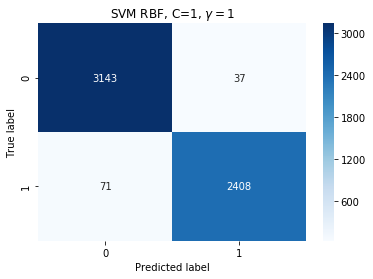

In [117]:
a = sns.heatmap(confusion_matrix(y_val_body,predict_svm_body), annot=True, cmap='Blues',fmt='g')
plt.title('SVM RBF, C=1, $\gamma=1$')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

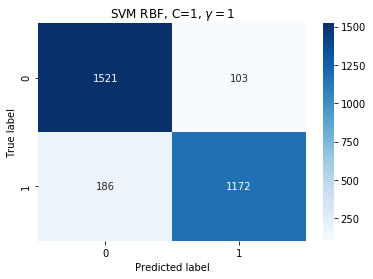

In [116]:
a = sns.heatmap(confusion_matrix(test_clases,test_svm_body), annot=True, cmap='Blues',fmt='g')
plt.title('SVM RBF, C=1, $\gamma=1$')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Cuerpos C=10 RBF $\gamma=1$

In [50]:
#Entrenamiento
svm_body = SVC(C = 10, kernel = 'rbf', gamma = 1)
svm_body.fit(tfIdf_train_body, y_train_body)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [51]:
#Prediccion
predict_svm_body = svm_body.predict(tfIdf_val_body)
test_svm_body = svm_body.predict(tfIdf_test_body)

#### Scores

##### Validacion

In [52]:
accuracy_score(y_val_body,predict_svm_body)

0.980915356069977

In [53]:
matthews_corrcoef(y_val_body,predict_svm_body)

0.9612489997750436

##### Testeo

In [54]:
accuracy_score(test_clases,test_svm_body)

0.9024144869215291

In [55]:
matthews_corrcoef(test_clases,test_svm_body)

0.8037622220184683

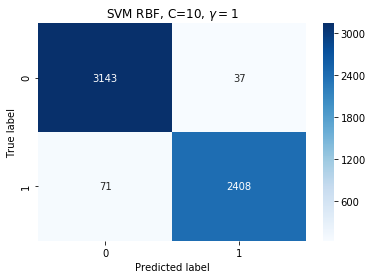

In [56]:
a = sns.heatmap(confusion_matrix(y_val_body,predict_svm_body), annot=True, cmap='Blues',fmt='g')
plt.title('SVM RBF, C=10, $\gamma=1$')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

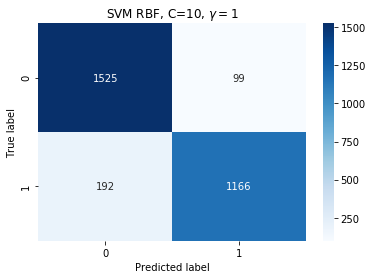

In [57]:
a = sns.heatmap(confusion_matrix(test_clases,test_svm_body), annot=True, cmap='Blues',fmt='g')
plt.title('SVM RBF, C=10, $\gamma=1$')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [99]:
texto = 'El actor indio Sanjay Dutt, una estrella de Bollywood cuya agitada vida sirvió de guion a un filme, sufre cáncer en un pulmón, informó este miércoles la prensa. Apodado el chico malo de Bollywood, Sanjay Dutt, de 61 años, salió de prisión en 2016 tras cuatro años entre rejas por posesión ilegal de armas, que presuntamente le fueron entregadas por personas implicadas en los atentados de Bombay del 12 de marzo de 1993 (257 muertos). El martes, Dutt publicó un comunicado en las redes sociales en que decía que estaba haciendo "una breve pausa para recibir tratamiento médico". Después, los medios citaron un tuit del periodista especializado Komal Nahta, según el cual sufre cáncer de pulmón y viajará a Estados Unidos para recibir tratamiento. Sanjay Dutt saltó a la palestra a mediados de la década de 1980 con filmes de acción en los que él mismo protagonizaba las escenas peligrosas. Pero, su vida dio un giro dramático al ser arrestado tras los atentados de Bombay. Casado tres veces, perdió a su primera esposa Richa, en 1996, quien padecía un tumor cerebral. En 2018, una película titulada "Sanju" recreó su ajetreada vida. Pensaba que tenía covid-19 The Times of India publicó este miércoles en exclusiva los detalles de cómo Dutt se enteró de que tenía cáncer, aunque sin citar fuentes. Según el medio, el pasado 8 de agosto el actor sintió dificultad para respirar y pensó que se había contagiado de coronavirus. Acompañado de su hermana y un amigo, Dutt se trasladó hasta un hospital donde tras examinarlo, los médicos detectaron problemas con su pulmón derecho. Por ello le practicaron un scanner que reveló acumulación de líquido y dos lesiones. Tras extraerle el líquido, este fue enviado a analizar. En paralelo, el actor fue sometido a un PET. Los resultados de ambos exámenes confirmaron el diagnóstico de cáncer. De acuerdo a The Times of India, el cáncer de pulmón debe tratarse con quimioterapia y por el momento no se contempla la opción de una cirugía.'
n = [' '.join(process_corpus(texto))]

svm_titles.predict(tfIdf_vectorizer_train_titles.transform(n))

array([1])

In [101]:
filename = 'tfidftitles.sav'
pickle.dump(tfIdf_vectorizer_train_titles, open(filename, 'wb'))

In [94]:
loaded_model = pickle.load(open(filename, 'rb'))

In [96]:
int(loaded_model.predict(tfIdf_vectorizer_train_body.transform(n)))

1

In [20]:
filename = 'svmtitles.sav'
titlemodel = pickle.load(open(filename, 'rb'))

In [21]:
filename = 'svmbody.sav'
bodymodel = pickle.load(open(filename, 'rb'))

In [22]:
pred_val = bodymodel.predict(tfIdf_val_body)

In [41]:
pred_test = bodymodel.predict(tfIdf_test_body)

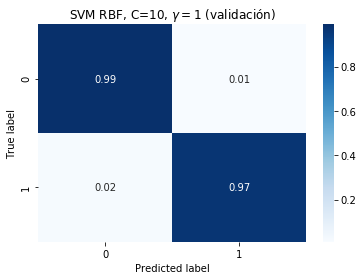

In [47]:
cm_val = confusion_matrix(y_val_body,pred_val)
cm_val = np.round(cm_val/ cm_val.astype(np.float).sum(axis=1),2)
a = sns.heatmap(cm_val, annot=True, cmap='Blues',fmt='g')
plt.title('SVM RBF, C=10, $\gamma=1$ (validación)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

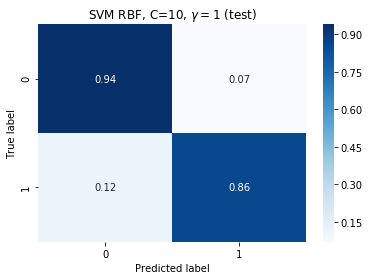

In [46]:
cm_test = confusion_matrix(test_clases,pred_test)
cm_test = np.round(cm_test/ cm_test.astype(np.float).sum(axis=1),2)
a = sns.heatmap(cm_test, annot=True, cmap='Blues',fmt='g')
plt.title('SVM RBF, C=10, $\gamma=1$ (test)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()